TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


4
0.91
[1.2197802197802199, 1.1428571428571428, 1.0989010989010988, 1.054945054945055, 1.0, 0.934065934065934, 0.8901098901098902, 0.7692307692307692]
[131.61985778808594, 152.4220733642578, 159.89950561523438, 171.74655151367188, 181.11985778808594, 188.35629272460938, 196.4479217529297, 210.53005981445312]
2c
10c
10c
5c
20c
1e
50c
2e


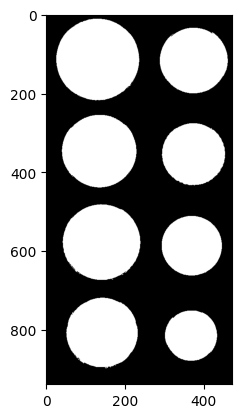

In [13]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

img = cv2.imread('Monedas.jpg') 
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th2,img_th2 = cv2.threshold(img_gris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos, hierarchy = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)
img_cont = np.zeros(img_rgb.shape)



proporciones = [1.11, 1.04, 1, 0.96, 0.91, 0.85,  0.81, 0.7]

tipo_de_moneda = ["2e", "50c", "1e", "20c", "5c", "10c",  "2c", "1c"]

def lista_proporcional(tipo):
    pos = tipo_de_moneda.index(tipo)
    print(pos)
    valor = proporciones[pos]
    print(valor)
    tamaño_proporcional = []
    for i in proporciones:
        tamaño_proporcional.append(i/valor)
    return tamaño_proporcional

proporciones = lista_proporcional("5c")
print(proporciones)

def hallar_valor(diametro_seleccionado, diametro_nuevo, proporciones):
    proporcion_calculada = diametro_nuevo/diametro_seleccionado
    valor_mas_cercano = 1
    pos = 0
    contador = -1
    for i in proporciones:
        if (abs(proporcion_calculada - i) < valor_mas_cercano):
            valor_mas_cercano = abs(proporcion_calculada - i)
            pos = contador
        contador +=1

    return tipo_de_moneda[pos]

diametros_usar = []
donde = 0
for cnt in contornos:
    area = cv2.contourArea(cnt)
    if area > 10000:
        #print(donde)
        #print(area)
        perimetro = cv2.arcLength(cnt,True)

        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(cnt)
        #Mínimo contenedor ajustado para el contorno
        rect = cv2.minAreaRect(cnt)
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(cnt)
        diametros_usar.append(radio*2)
        #Elipse ajustada al contorno, exgigiendo un mínimo de puntos del contornos
        if cnt.shape[0] > 5:
            elipse = cv2.fitEllipse(cnt)
        cv2.drawContours(img_cont, [cnt], -1, (255,255,255), -1)
    donde+=1
plt.imshow(img_cont)
diametros_usar = sorted(diametros_usar)
moneda = diametros_usar[4]
print(diametros_usar)
for i in diametros_usar:
    print(hallar_valor(moneda, i, proporciones))          


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y aprender patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test MPs_test.jpg y sus correpondientes anotaciones MPs_test_bbs.csv con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases

In [116]:
import cv2
import numpy as np
import pandas as pd

def calcular_medias_contornos(contornos, area_min, clase):
    if len(contornos) == 0:
        return (0, 0, 0, 0, 0), pd.DataFrame()

    suma_area = suma_perimetro = suma_comp = suma_AR = suma_solidez = suma_intensidad = 0
    contador_validos = 0
    datos = []  

    for cnt in contornos:
        area = cv2.contourArea(cnt)
        if area > area_min:
            perimetro = cv2.arcLength(cnt, True)
            compacidad = (perimetro ** 2) / (4 * np.pi * area) if area > 0 else 0

            x, y, w, h = cv2.boundingRect(cnt)
            AR = w / h if h > 0 else 0

            hull = cv2.convexHull(cnt)
            hull_area = cv2.contourArea(hull)
            solidez = area / hull_area if hull_area > 0 else 0

            mask_contour = np.zeros(img_gris.shape, np.uint8)
            cv2.drawContours(mask_contour, [cnt], -1, 255, -1)
            media_color = cv2.mean(img_gris, mask=mask_contour)[0]

            # Acumular para las medias
            suma_area += area
            suma_perimetro += perimetro
            suma_comp += compacidad
            suma_AR += AR
            suma_solidez += solidez
            suma_intensidad += media_color
            contador_validos += 1

            # Guardar los valores individuales
            datos.append({
                "area": area,
                "perimeter": perimetro,
                "compacidad": compacidad,
                "AR": AR,
                "solidity": solidez,
                "intensity": media_color,
                "true_class": clase
            })

    if contador_validos == 0:
        contador_validos = 1

    # Crear DataFrame con los valores
    df = pd.DataFrame(datos)

    return (
        suma_area / contador_validos,
        suma_perimetro / contador_validos,
        suma_comp / contador_validos,
        suma_AR / contador_validos,
        suma_solidez / contador_validos,
        suma_intensidad / contador_validos
    ), df


img_fragments = cv2.imread("FRA.png")
img_pellets = cv2.imread("PEL.png")
img_tar = cv2.imread("TAR.png")

# Fragmentos
img_gris = cv2.cvtColor(img_fragments, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
(medias_frag, df_frag) = calcular_medias_contornos(contornos, 100, "FRA")

# Pellets
img_gris = cv2.cvtColor(img_pellets, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
(medias_pel, df_pel) = calcular_medias_contornos(contornos, 100, "PEL")

# Tar
img_gris = cv2.cvtColor(img_tar, cv2.COLOR_BGR2GRAY)
_, img_th2 = cv2.threshold(img_gris, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contornos, _ = cv2.findContours(img_th2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
(medias_tar, df_tar) = calcular_medias_contornos(contornos, 100, "TAR")

# ---- Unir todos los resultados ----
print(df_frag[["area", "compacidad", "AR", "solidity", "intensity"]])
print(df_pel[["area", "compacidad", "AR", "solidity", "intensity"]])
print(df_tar[["area", "compacidad", "AR", "solidity", "intensity"]])

df_total = pd.concat([df_frag, df_pel, df_tar], ignore_index=True)


# ---- Mostrar resumen ----
print("Medias")
print(f"FRA -> Área: {medias_frag[0]:.2f}, Compacidad: {medias_frag[2]:.2f}, AR: {medias_frag[3]:.2f}, Solidez: {medias_frag[4]:.2f}, Intensidad: {medias_frag[5]:.2f}")
print(f"PEL -> Área: {medias_pel[0]:.2f}, Compacidad: {medias_pel[2]:.2f}, AR: {medias_pel[3]:.2f}, Solidez: {medias_pel[4]:.2f}, Intensidad: {medias_pel[5]:.2f}")
print(f"TAR -> Área: {medias_tar[0]:.2f}, Compacidad: {medias_tar[2]:.2f}, AR: {medias_tar[3]:.2f}, Solidez: {medias_tar[4]:.2f}, Intensidad: {medias_tar[5]:.2f}")

      area  compacidad        AR  solidity   intensity
0    835.5    4.641455  2.000000  0.594662  115.309753
1   6134.5    1.567943  0.978495  0.926872  116.218034
2   4342.5    1.566237  0.908046  0.958186   91.344519
3   6345.5   12.762850  1.097561  0.584596  117.538689
4   9415.0    1.836486  1.967033  0.921909  114.518715
5   1146.0    4.831013  3.038462  0.729240  120.345512
6   1667.0    4.481353  3.125000  0.710571  119.380979
7    137.0    4.457155  1.562500  0.599562  120.340909
8    645.5    9.121253  1.291667  0.345095  117.729659
9   7311.0    1.475569  1.142857  0.934791  110.106426
10  1712.0    1.467471  0.857143  0.945595  112.761878
11  4738.5    1.491429  1.083333  0.955246   92.490961
     area  compacidad        AR  solidity  intensity
0  3761.0    1.214903  0.958333  0.979427  67.918996
1  3934.0    1.273743  0.887500  0.970041  73.549864
2  4136.5    1.174031  1.041667  0.981609  75.956870
3  2544.0    1.293333  0.983051  0.963454  81.583745
4  4740.0    1.20369

Datos cargados:
  label  x_min  y_min  x_max  y_max
0   TAR    503   1171    532   1186
1   TAR    204   1103    244   1133
2   TAR     16   1086     44   1118
3   TAR    524   1022    545   1048
4   TAR    408    975    433    997

===== MÉTRICAS =====
Accuracy: 0.7216494845360825
Precision: 0.7737374869266397
Recall: 0.7216494845360825
F1: 0.7415601023848446


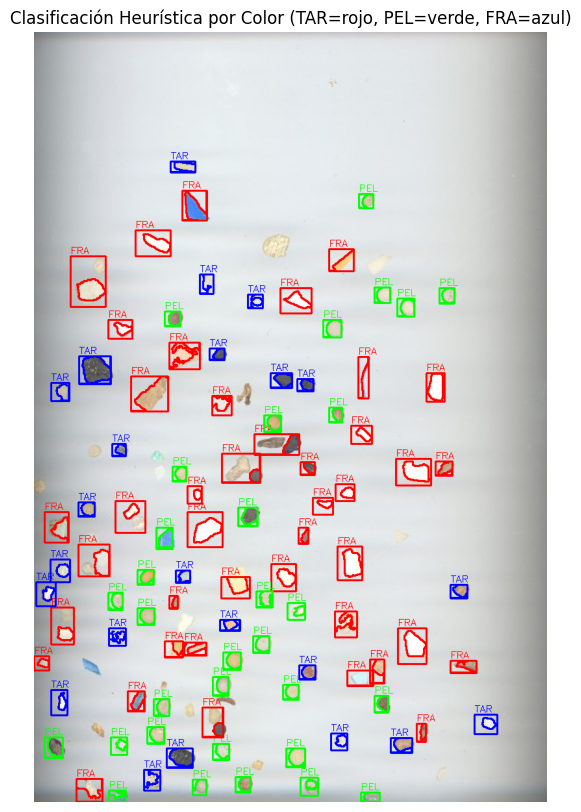

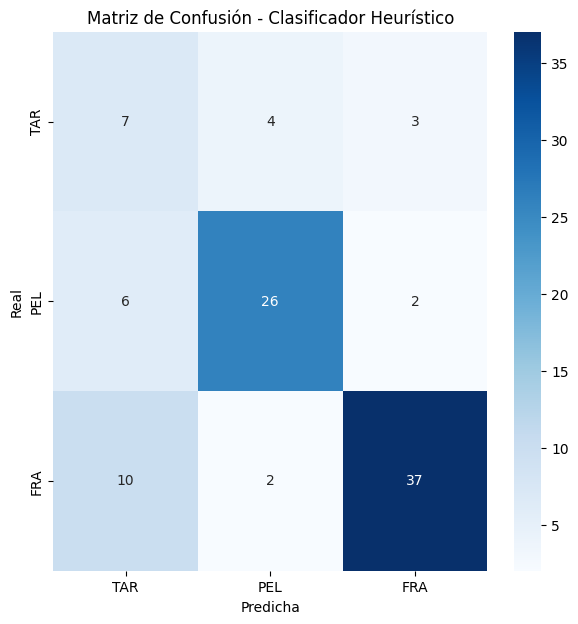


Resultados finales:
      area   perimeter  compacidad        AR  solidity   intensity true_class  \
0     67.0   52.485281    3.271827  1.071429  0.542510  205.021505        TAR   
1    329.5  155.355338    5.828906  1.333333  0.380046  226.002481        TAR   
2    268.0  124.627417    4.611928  0.875000  0.427432  202.585366        TAR   
3    202.5  104.041630    4.253823  0.807692  0.448009  233.896825        TAR   
4    141.0  108.627417    6.659627  1.136364  0.333333  224.937824        TAR   
5    199.0   96.627417    3.733686  0.600000  0.592262  229.779592        TAR   
6    323.0  145.941125    5.247386  1.034483  0.447368  234.061224        TAR   
7    164.0   80.627417    3.154364  1.100000  0.604052  228.678218        TAR   
8    168.5  105.213203    5.227941  1.105263  0.468056  232.785388        TAR   
9   1551.0  205.112698    2.158557  2.156250  0.831635  189.728485        TAR   
10   177.0  125.455844    7.076177  1.315789  0.409722  232.042194        TAR   
11   29

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

#Cargar imágenes y csv
csv_path = "MPs_test_bbs.csv"
bbs = pd.read_csv(csv_path)
print("Datos cargados:")
print(bbs.head())

img = cv2.imread("MPs_test.jpg")
img_draw = img.copy()

features = []

#Vamos revisando las coordenadas del csv para tratar los fragmentos de la imagen
for i, row in bbs.iterrows():
    x_min, y_min, x_max, y_max = map(int, [row["x_min"], row["y_min"], row["x_max"], row["y_max"]])
    #Guardamos su clase real
    true_class = row["label"]

    x_min = max(0, x_min); y_min = max(0, y_min)
    x_max = min(img.shape[1]-1, x_max); y_max = min(img.shape[0]-1, y_max)
    if x_max <= x_min or y_max <= y_min:
        continue

    #Obtengo un recorte de la imagen que luego paso a escala de grises  
    recorte = img[y_min:y_max, x_min:x_max]
    gray = cv2.cvtColor(recorte, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)


    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        continue

    cnt = max(contours, key=cv2.contourArea)
    #Traduce las coordenadas del recorte a la imagen original
    cnt_global = cnt + np.array([[x_min, y_min]])

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    #Calcula como de irregular es la forma, 1 = círculo perfecto, 1> irregular.
    compacidad = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0
    x2, y2, w2, h2 = cv2.boundingRect(cnt)
    #Comprueba como de alargado (>1) o cuadrado (~1) es el objeto
    AR = w2 / h2 if h2 > 0 else 0
    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0
    mask_contour = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask_contour, [cnt], -1, 255, -1)
    media_color = cv2.mean(gray, mask=mask_contour)[0] 

    #Guardar todas las características de cada elemento 
    # del CSV que se ha buscado en la imagen
    features.append({
        "area": area,
        "perimeter": perimeter,
        "compacidad": compacidad,
        "AR": AR,
        "solidity": solidity,
        "intensity": media_color,
        "true_class": true_class,
        "bbox": (x_min, y_min, x_max, y_max),
        "contour": cnt_global
    })


df = pd.DataFrame(features)


#Clasificador heurístico
def clasificar(f):
    area = f["area"]
    comp = f["compacidad"]
    AR = f["AR"]
    sol = f["solidity"]
    intensity = f["intensity"]

    # Rama 1: objetos con solidez baja 
    if sol <= 0.5:
        # Si son alargados y muy brillantes -> FRAG, si son relativamente brillantes -> TAR
        if AR > 1.1:
            if intensity >= 235:
                return "FRA"
            else:
                return "TAR"
        # Resto en esta rama -> PEL
        else:
            return "PEL"

    # Rama 2: solidez alta 
    else:
        # objetos muy pequeños 
        if area <= 200:
            if intensity <= 215:
                return "PEL"
            else:
                return "FRA"

        # objetos de tamaño medio
        elif area <= 380:
            if intensity <= 205:
                return "PEL"
            else:
                return "FRA"

        # objetos grandes 
        else:
            return "FRA"



if not df.empty:
    df["pred_class"] = df.apply(clasificar, axis=1)

    color_dict = {"TAR": (255, 0, 0), "PEL": (0, 255, 0), "FRA": (0, 0, 255) }
    #Dibujar cajas y escribir caja que ha predicho
    for _, row in df.iterrows():
        x_min, y_min, x_max, y_max = row["bbox"]
        color = color_dict.get(row["pred_class"], (255, 255, 255))
        cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.drawContours(img_draw, [row["contour"]], -1, color, 2)
        cv2.putText(img_draw, row["pred_class"], (x_min, max(y_min-4, 0)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    y_true = df["true_class"]
    y_pred = df["pred_class"]

    print("\n===== MÉTRICAS =====")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average="weighted", zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, average="weighted", zero_division=0))
    print("F1:", f1_score(y_true, y_pred, average="weighted", zero_division=0))

img_show = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_show)
plt.axis("off")
plt.title("Clasificación Heurística por Color (TAR=rojo, PEL=verde, FRA=azul)")
plt.show()

# Matriz de confusión
labels = ["TAR", "PEL", "FRA"]
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(7,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Clasificador Heurístico")
plt.show()

# Resultados finales
print("\nResultados finales:")
print(df[["area", "perimeter", "compacidad", "AR", "solidity", "intensity", "true_class", "pred_class"]])